## Project 2 - Movie Genre Classification
#### Jorge Madrid _jl.madrid@uniandes.edu.co_
#### Arturo Guerrero _ga.guerrero@uniandes.edu.co_

Classify a movie genre based on its plot.

<img src="https://github.com/ggrmos/Projects/blob/master/DataMining/Project_2_Movie_Genre_Classification/MV5BMTc5MDE2ODcwNV5BMl5BanBnXkFtZTgwMzI2NzQ2NzM@._V1_SY1000_CR0,0,674,1000_AL_.jpg?raw=true"
     style="float: left; width:337px;height:500px;margin-right: 10px;" />
     
    After the devastating events of Vengadores: Infinity War (2018), the universe is in ruins. With the help of remaining allies, the Avengers assemble once more in order to undo Thanos' actions and restore order to the universe. Adrift in space with no food or water, Tony Stark sends a message to Pepper Potts as his oxygen supply starts to dwindle. Meanwhile, the remaining Avengers -- Thor, Black Widow, Captain America and Bruce Banner -- must figure out a way to bring back their vanquished allies for an epic showdown with Thanos -- the evil demigod who decimated the planet and the universe.

<img src="https://github.com/ggrmos/Projects/blob/master/DataMining/Project_2_Movie_Genre_Classification/predict_endgame.png?raw=true"
     style="float:right; width:600px;height:300px;margin-right: 10px;" />
     


### Data

Input:
- movie plot

Output:
Probability of the movie belong to each genre


### Evaluation

- 20% API
- 30% Create a solution using with a Machine Learning algorithm - Presentation (5 slides)
- 50% Performance in the Kaggle competition (Normalized acording to class performance in the private leaderboard)


### Acknowledgements

We thank Professor Fabio Gonzalez, Ph.D. and his student John Arevalo for providing this dataset.

See https://arxiv.org/abs/1702.01992

----

### Methodology

<img src="https://github.com/ggrmos/Projects/blob/master/DataMining/Project_2_Movie_Genre_Classification/OverView_.png?raw=true"
     style="float: left; width:856px;height:422px;margin-right: 10px;" />

### 1. Data exploration

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import wordnet as wn
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, roc_auc_score, accuracy_score, mean_squared_error
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from sklearn.base import clone
from wordcloud import WordCloud
import inflect
import re
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
dataTraining = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

dataTraining['genres'] = dataTraining['genres'].map(lambda x: (eval(x)))

Setting max text to display

In [3]:
pd.set_option('display.max_colwidth', 200)

Let's take a first contact with the data. 

In [ ]:
dataTraining.head(20)

We looks data is composed by publication year, movie title, movie plot, a list of genre associated to the movie and rating. We gonna be concentrated in plot movie. Let's take a plot sample, belong we shows the _"Pursuit to Algiers"_ plot.

In [4]:
dataTraining['plot'][1945]

'a comedy which revolves around three disparate women -  - a buttoned down lawyer from chicago ,  a miami cocktail waitress ,  and a wealthy ,  sheltered new yorker -  - who discover they share something in common :  a boyfriend from l . a .  unfortunately ,  they are all involved with the same irresistible ,  charming lothario who has been three - timing them across the country ,  with great expertise .  they decide to teach their papi chulo a lesson ,  but instead end up on a wild adventure of their own ,  which takes them to a beauty pageant ,  a dance festival ,  and into some dangerous run - ins with a pair of shady characters .'

Data have symbols and special characters to be remove in next steps. This movie belong to four differents genres, it might be beneficial to see which genres co-occur, as it might shed some light on inherent biases in our dataset. For example, it would make sense if romance and comedy occur together more often than documentary and comedy. Such inherent biases tell us that the underlying population we are sampling from itself is skewed and not balanced

In [5]:
import itertools
def list2pairs(l):
    # itertools.combinations(l,2) makes all pairs of length 2 from list l.
    pairs = list(itertools.combinations(l, 2))
    # then the one item pairs, as duplicate pairs aren't accounted for by itertools
    for i in l:
        pairs.append([i,i])
    return pairs

In [6]:
# get all genre lists pairs from all movies
allPairs = []
for movie in dataTraining['genres']:
    allPairs.extend(list2pairs(movie))

In [7]:
allPairs[0:5]

[('Short', 'Drama'),
 ['Short', 'Short'],
 ['Drama', 'Drama'],
 ('Comedy', 'Crime'),
 ('Comedy', 'Horror')]

In [8]:
nr_ids = np.unique(allPairs)
visGrid = np.zeros((len(nr_ids), len(nr_ids)))
for p in allPairs:
    visGrid[np.argwhere(nr_ids==p[0]), np.argwhere(nr_ids==p[1])]+=1
    if p[1] != p[0]:
        visGrid[np.argwhere(nr_ids==p[1]), np.argwhere(nr_ids==p[0])]+=1

In [10]:
print(visGrid.shape)

(24, 24)


In [9]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

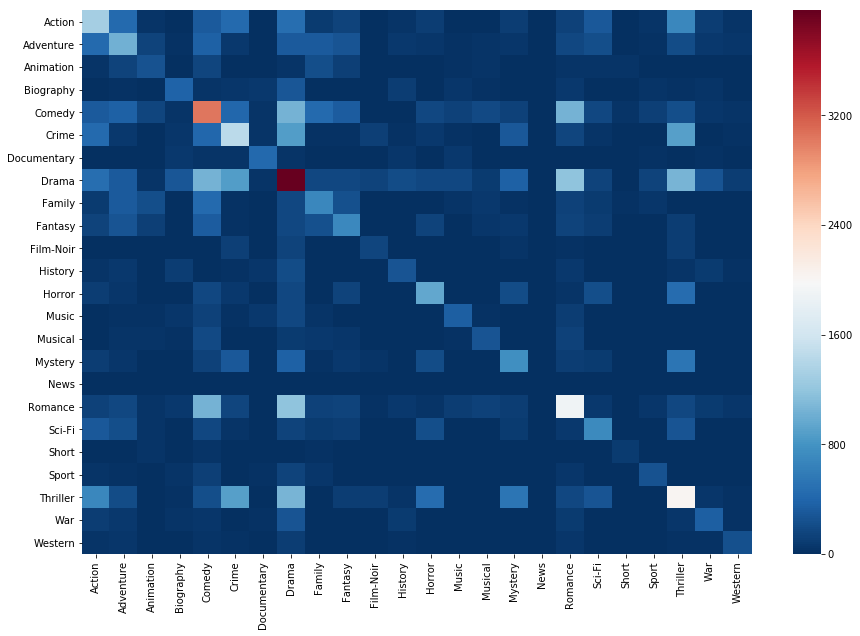

In [10]:
import seaborn as sns
plt.subplots(figsize=(15,10))

sns.heatmap(visGrid, xticklabels=nr_ids, yticklabels=nr_ids, cmap="RdBu_r")

The figure above, shows something special things, the diagonal corresponds to self-pairs, i.e number of times a genre, say Drama ocurred with Drama. Which basically just a count of the total times that genre ocurred.

As we can see there are a lot of dramas in the data set, it is also a very unspecific label. There are nearly no documentaries or TV Movies. Horror is a very distinct label, and romance is also not too widely spread.

To account for this unbalanced data, there are multiple things we can try to explore what interesting relationships can be found or take care in the next steps

### 2. Data Cleaning

_Clean text_ function remove special chars found in the data plot

In [4]:
def clean_text(df):
    sentence = df['plot']
    sentence = sentence.replace('u . s .', 'united state', regex=True)
    #sentence = sentence.replace('[,.:()"-]', '', regex=True)
    sentence = sentence.replace('\s*\,\s*', ', ', regex=True)
    sentence = sentence.replace('\s*\.\s*', '. ', regex=True)
    sentence = sentence.replace('\s*\.', '.', regex=True)
    sentence = sentence.replace('\s*\:\s*', ': ', regex=True)
    sentence = sentence.replace("i ' m", 'i am', regex=True)
    sentence = sentence.replace("she ' s", 'she is', regex=True)
    sentence = sentence.replace("he ' s", 'he is', regex=True)
    sentence = sentence.replace("it ' s", 'it is', regex=True)
    sentence = sentence.replace("there ' s", 'there is', regex=True)
    sentence = sentence.replace("that ' s", 'that is', regex=True)
    sentence = sentence.replace("what ' s", 'what is', regex=True)
    sentence = sentence.replace("' s", '', regex=True)
    sentence = sentence.replace("' re", ' are', regex=True)
    sentence = sentence.replace("' ll", ' will', regex=True)
    sentence = sentence.replace("' ve", ' have', regex=True)
    sentence = sentence.replace("' d", ' would', regex=True)
    sentence = sentence.replace("can ' t", 'cannot', regex=True)
    sentence = sentence.replace("n ' t", ' not', regex=True)
    sentence = sentence.replace("let ' s", 'let us', regex=True)
    sentence = sentence.replace("dr", 'doctor', regex=True)
    sentence = sentence.replace(" ' ", "'", regex=True)
    sentence = sentence.replace("  ", ' ', regex=True)
    sentence = sentence.replace("  ", ' ', regex=True)
    sentence = sentence.replace("ë", 'e', regex=True)
    sentence = sentence.replace("á", 'a', regex=True)
    sentence = sentence.replace("é", 'e', regex=True)
    sentence = sentence.replace("í", 'i', regex=True)
    sentence = sentence.replace("ó", 'o', regex=True)
    sentence = sentence.replace("ú", 'u', regex=True)
    sentence = sentence.replace("ô", 'o', regex=True)
    sentence = sentence.replace("ü", 'u', regex=True)
    sentence = sentence.replace("æ", 'a', regex=True)
    
    
    sentence = sentence.str.strip(' ')
    df['plot'] = sentence
    return df
    

In [12]:
dataTraining['plot'][3107]

'most is the story of a single father who takes his eight year - old son to work with him at the railroad drawbridge where he is the bridge tender .  a day before ,  the boy meets a woman boarding a train ,  a drug abuser .  at the bridge ,  the father goes into the engine room ,  and tells his son to stay at the edge of the nearby lake .  a ship comes ,  and the bridge is lifted .  though it is supposed to arrive an hour later ,  the train happens to arrive .  the son sees this ,  and tries to warn his father ,  who is not able to see this .  just as the oncoming train approaches ,  his son falls into the drawbridge gear works while attempting to lower the bridge ,  leaving the father with a horrific choice .  the father then lowers the bridge ,  the gears crushing the boy .  the people in the train are completely oblivious to the fact a boy died trying to save them ,  other than the drug addict woman ,  who happened to look out her train window .  the movie ends ,  with the man wande

In [5]:
dataTraining = clean_text(dataTraining)

In [14]:
dataTraining['plot'][3107]

'most is the story of a single father who takes his eight year - old son to work with him at the railroad doctorawbridge where he is the bridge tender. a day before, the boy meets a woman boarding a train, a doctorug abuser. at the bridge, the father goes into the engine room, and tells his son to stay at the edge of the nearby lake. a ship comes, and the bridge is lifted. though it is supposed to arrive an hour later, the train happens to arrive. the son sees this, and tries to warn his father, who is not able to see this. just as the oncoming train approaches, his son falls into the doctorawbridge gear works while attempting to lower the bridge, leaving the father with a horrific choice. the father then lowers the bridge, the gears crushing the boy. the people in the train are completely oblivious to the fact a boy died trying to save them, other than the doctorug addict woman, who happened to look out her train window. the movie ends, with the man wandering a new city, and meets the

### 2.1 Lematization

Its necesary apply methods to grouping together the different inflected forms of a word to be analysed as a single item. We choice a lematizer method above stemming but it brings context to the words.

In [15]:
sentence = dataTraining['plot'][3107]
wordnet_lemmatizer = WordNetLemmatizer()
words = nltk.word_tokenize(sentence)

new_sentence = []
for i, word in enumerate(words):
    new_word = wordnet_lemmatizer.lemmatize(word)
    new_sentence.append(new_word)

s = ' '.join(new_sentence)

In [16]:
s

'most is the story of a single father who take his eight year - old son to work with him at the railroad doctorawbridge where he is the bridge tender . a day before , the boy meet a woman boarding a train , a doctorug abuser . at the bridge , the father go into the engine room , and tell his son to stay at the edge of the nearby lake . a ship come , and the bridge is lifted . though it is supposed to arrive an hour later , the train happens to arrive . the son see this , and try to warn his father , who is not able to see this . just a the oncoming train approach , his son fall into the doctorawbridge gear work while attempting to lower the bridge , leaving the father with a horrific choice . the father then lower the bridge , the gear crushing the boy . the people in the train are completely oblivious to the fact a boy died trying to save them , other than the doctorug addict woman , who happened to look out her train window . the movie end , with the man wandering a new city , and me

With the above text example, the sentence _"...a day before the boy __meets__ a woman boarding a train..."_ change to _"...a day before the boy __meet__ a woman boarding a train..."_.

Some verbs may will traited a little different. We use a tag word method to specified the form and lematizer application.

In [17]:
role = nltk.pos_tag(words)
role

[('most', 'RBS'),
 ('is', 'VBZ'),
 ('the', 'DT'),
 ('story', 'NN'),
 ('of', 'IN'),
 ('a', 'DT'),
 ('single', 'JJ'),
 ('father', 'NN'),
 ('who', 'WP'),
 ('takes', 'VBZ'),
 ('his', 'PRP$'),
 ('eight', 'CD'),
 ('year', 'NN'),
 ('-', ':'),
 ('old', 'JJ'),
 ('son', 'NN'),
 ('to', 'TO'),
 ('work', 'VB'),
 ('with', 'IN'),
 ('him', 'PRP'),
 ('at', 'IN'),
 ('the', 'DT'),
 ('railroad', 'NN'),
 ('doctorawbridge', 'NN'),
 ('where', 'WRB'),
 ('he', 'PRP'),
 ('is', 'VBZ'),
 ('the', 'DT'),
 ('bridge', 'NN'),
 ('tender', 'NN'),
 ('.', '.'),
 ('a', 'DT'),
 ('day', 'NN'),
 ('before', 'IN'),
 (',', ','),
 ('the', 'DT'),
 ('boy', 'NN'),
 ('meets', 'VBZ'),
 ('a', 'DT'),
 ('woman', 'NN'),
 ('boarding', 'VBG'),
 ('a', 'DT'),
 ('train', 'NN'),
 (',', ','),
 ('a', 'DT'),
 ('doctorug', 'JJ'),
 ('abuser', 'NN'),
 ('.', '.'),
 ('at', 'IN'),
 ('the', 'DT'),
 ('bridge', 'NN'),
 (',', ','),
 ('the', 'DT'),
 ('father', 'NN'),
 ('goes', 'VBZ'),
 ('into', 'IN'),
 ('the', 'DT'),
 ('engine', 'NN'),
 ('room', 'NN'),
 (','

In [18]:
VERB_CODES = {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', } # pos = 'v'

ADJ_CODES = {'JJ','JJR','JJS'} # pos='a'

ADV_CODES = {'RB','RBR','RBS'} #pos='r'

NOUN_CODES = {'NN', 'NNP','NNS','NNPS'} # pos = 'n'

new_sentence=[]
role = nltk.pos_tag(words)
for i, word in enumerate(words):
    if role[i][1] in VERB_CODES: 
        new_word = wordnet_lemmatizer.lemmatize(word, 'v')
    else:
        if role[i][1] in ADJ_CODES: 
            new_word = wordnet_lemmatizer.lemmatize(word, 'a')
        else:
            if role[i][1] in ADV_CODES: 
                new_word = wordnet_lemmatizer.lemmatize(word, 'r')
            else:
                if role[i][1] in NOUN_CODES: 
                    new_word = wordnet_lemmatizer.lemmatize(word, 'n') 
                else:
                    new_word = wordnet_lemmatizer.lemmatize(word)

    new_sentence.append(new_word)
    
s = ' '.join(new_sentence)        

In [19]:
s

'most be the story of a single father who take his eight year - old son to work with him at the railroad doctorawbridge where he be the bridge tender . a day before , the boy meet a woman board a train , a doctorug abuser . at the bridge , the father go into the engine room , and tell his son to stay at the edge of the nearby lake . a ship come , and the bridge be lift . though it be suppose to arrive an hour later , the train happen to arrive . the son see this , and try to warn his father , who be not able to see this . just a the oncoming train approach , his son fall into the doctorawbridge gear work while attempt to lower the bridge , leave the father with a horrific choice . the father then lower the bridge , the gear crush the boy . the people in the train be completely oblivious to the fact a boy die try to save them , other than the doctorug addict woman , who happen to look out her train window . the movie end , with the man wander a new city , and meet the woman , no longer 

_"...the bridge the gear __crushing__ the boy..."_ change to:
_"...the bridge the gear __crush__ the boy..."_

### 2.2 Stop words

We use a pre defined stop words english dictionary from nltk module

In [20]:
stop = set(stopwords.words('english'))
stop

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [21]:
new_sentence = []
for i, word in enumerate(words):
    if word not in stop and word.isalpha() and len(word)>1:
        new_sentence.append(word)
s = ' '.join(new_sentence)

In [22]:
s

'story single father takes eight year old son work railroad doctorawbridge bridge tender day boy meets woman boarding train doctorug abuser bridge father goes engine room tells son stay edge nearby lake ship comes bridge lifted though supposed arrive hour later train happens arrive son sees tries warn father able see oncoming train approaches son falls doctorawbridge gear works attempting lower bridge leaving father horrific choice father lowers bridge gears crushing boy people train completely oblivious fact boy died trying save doctorug addict woman happened look train window movie ends man wandering new city meets woman longer doctorug addict holding small baby relevant narratives run parallel namely one female doctorug addict meet climax tumultuous film'

## Putting all together

In [6]:
def clean_sentence(sentence):
    sentence = sentence.lower()
    sentence = sentence.replace('u . s .', 'united state')
    sentence = re.sub(r'\s*\,\s*', ', ', sentence)
    sentence = re.sub(r'\s*\.\s*', '. ', sentence)
    sentence = re.sub(r'\s*\.', '.', sentence)
    sentence = re.sub('\s*\:\s*', ': ', sentence)
    sentence = sentence.replace("i ' m", 'i am')
    sentence = sentence.replace("she ' s", 'she is')
    sentence = sentence.replace("he ' s", 'he is')
    sentence = sentence.replace("it ' s", 'it is')
    sentence = sentence.replace("there ' s", 'there is')
    sentence = sentence.replace("that ' s", 'that is')
    sentence = sentence.replace("what ' s", 'what is')
    sentence = sentence.replace("' s", '')
    sentence = sentence.replace("' re", ' are')
    sentence = sentence.replace("' ll", ' will')
    sentence = sentence.replace("' ve", ' have')
    sentence = sentence.replace("' d", ' would')
    sentence = sentence.replace("can ' t", 'cannot')
    sentence = sentence.replace("n ' t", ' not')
    sentence = sentence.replace("let ' s", 'let us')
    sentence = sentence.replace("dr", 'doctor')
    sentence = sentence.replace(" ' ", "'")
    sentence = sentence.replace("  ", ' ')
    sentence = sentence.replace("  ", ' ')
    sentence = sentence.replace("ë", 'e')
    sentence = sentence.replace("á", 'a')
    sentence = sentence.replace("é", 'e')
    sentence = sentence.replace("í", 'i')
    sentence = sentence.replace("ó", 'o')
    sentence = sentence.replace("ú", 'u')
    sentence = sentence.replace("ô", 'o')
    sentence = sentence.replace("ü", 'u')
    sentence = sentence.replace("æ", 'a')
    sentence = sentence.replace("n't", " not")
    sentence = sentence.replace("'s", " is")
    sentence = sentence.replace("'re"," are")
    sentence = sentence.replace("'d", " would")
    sentence = sentence.replace("'ve", " have")
    sentence = sentence.replace("'ll", " will")
    sentence = sentence.replace("'m", " am")
    wordnet_lemmatizer = WordNetLemmatizer()
    stop = set(stopwords.words('english'))
    VERB_CODES = {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', }
    ADJ_CODES = {'JJ','JJR','JJS'}
    ADV_CODES = {'RB','RBR','RBS'}
    NOUN_CODES = {'NN', 'NNP','NNS','NNPS'}
    
    new_sentence = []
    words = nltk.word_tokenize(sentence)
    role = nltk.pos_tag(words)
    
    for i, word in enumerate(words):
        if role[i][1] in VERB_CODES: 
            new_word = wordnet_lemmatizer.lemmatize(word, 'v')
        else:
            if role[i][1] in ADJ_CODES: 
                new_word = wordnet_lemmatizer.lemmatize(word, 'a')
            else:
                if role[i][1] in ADV_CODES: 
                    new_word = wordnet_lemmatizer.lemmatize(word, 'r')
                else:
                    if role[i][1] in NOUN_CODES: 
                        new_word = wordnet_lemmatizer.lemmatize(word, 'n') 
                    else:
                        new_word = wordnet_lemmatizer.lemmatize(word)
            
        if new_word not in stop and new_word.isalpha() and len(new_word)>1:
            new_sentence.append(new_word)
        
    s = ' '.join(new_sentence)
    return s    

In [7]:
dataTraining['plot'] = dataTraining['plot'].apply(clean_sentence)

In [25]:
dataTraining['plot'][3107]

'story single father take eight year old son work railroad doctorawbridge bridge tender day boy meet woman board train doctorug abuser bridge father go engine room tell son stay edge nearby lake ship come bridge lift though suppose arrive hour later train happen arrive son see try warn father able see oncoming train approach son fall doctorawbridge gear work attempt lower bridge leave father horrific choice father lower bridge gear crush boy people train completely oblivious fact boy die try save doctorug addict woman happen look train window movie end man wander new city meet woman longer doctorug addict hold small baby relevant narrative run parallel namely one female doctorug addict meet climax tumultuous film'

### 3. Initial Target definition

In [8]:
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

In [9]:
genres = le.classes_

In [28]:
y_genres[0]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0])

In [29]:
genres

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
       'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War',
       'Western'], dtype=object)

### 4. Words exploration

In order to check the multiclass classification, we gonna explore if some words are mostly used over the 24 genres class

In [10]:
dataTraining['genres_encoded'] = list(y_genres)
cols = np.reshape(list(le.classes_), (24, 1)).T[0]

#Explode genre list to columns

dataTraining[np.reshape(list(le.classes_), (24, 1)).T[0]] = pd.DataFrame(dataTraining.genres_encoded.values.tolist(), index= dataTraining.index)
dataTraining.drop(['genres_encoded'],axis=1, inplace=True)

In [32]:
pd.set_option('display.max_colwidth', 10)
dataTraining.head()

,year,title,plot,genres,rating,Action,Adventure,Animation,Biography,Comedy,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
3107,2003,Most,story ...,[Short...,8.00000,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
900,2008,How to...,serial...,[Comed...,5.60000,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6724,1941,A Woma...,sweden...,[Drama...,7.20000,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4704,1954,Execut...,friday...,[Drama],7.40000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2582,1990,Narrow...,los an...,[Actio...,6.60000,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Let's check most used words by Drama, Action and News genres

#### Drama

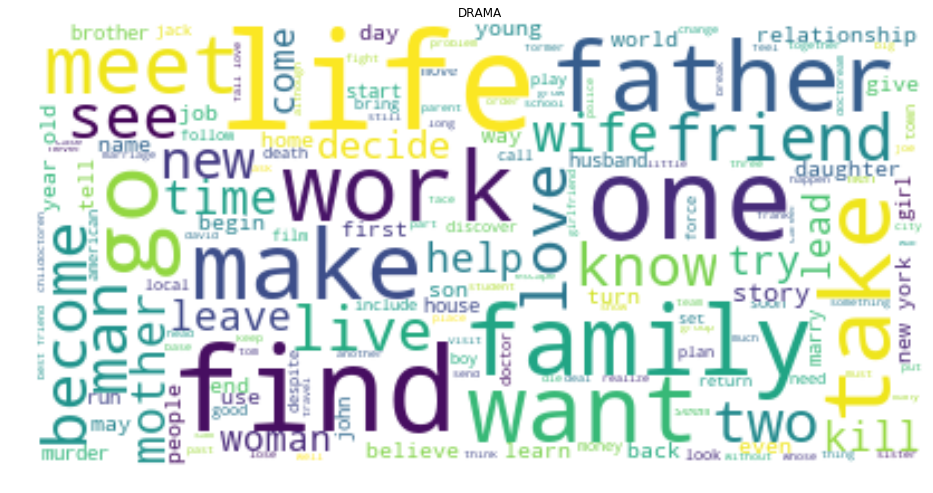

In [33]:
text = dataTraining['plot'][dataTraining['Drama']==1].str.cat(sep=' ')#.map(lambda x: ''.join(x))
wordcloud = WordCloud(max_font_size=60, background_color="white").generate(text)
plt.figure(figsize=(16,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('DRAMA')
plt.show()

#### War

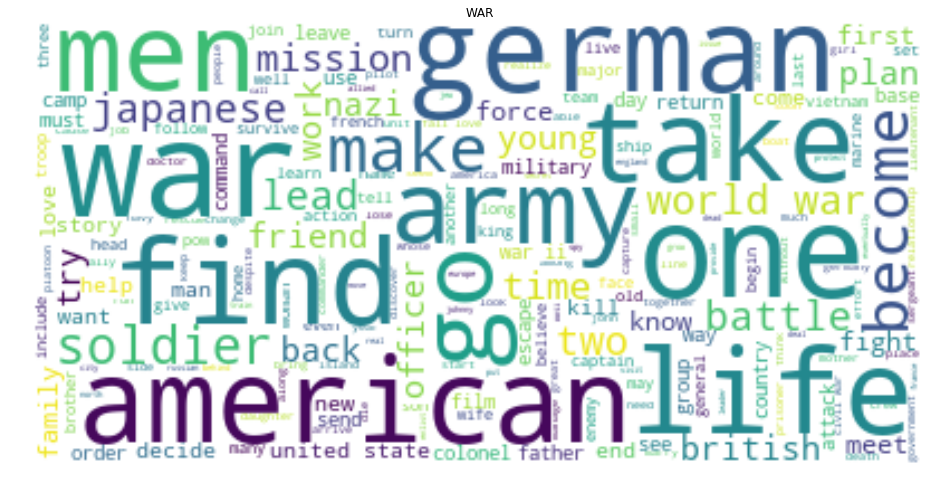

In [34]:
text = dataTraining['plot'][dataTraining['War']==1].str.cat(sep=' ')#.map(lambda x: ''.join(x))
wordcloud = WordCloud(max_font_size=60, background_color="white").generate(text)
plt.figure(figsize=(16,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('WAR')
plt.show()

#### Documentary

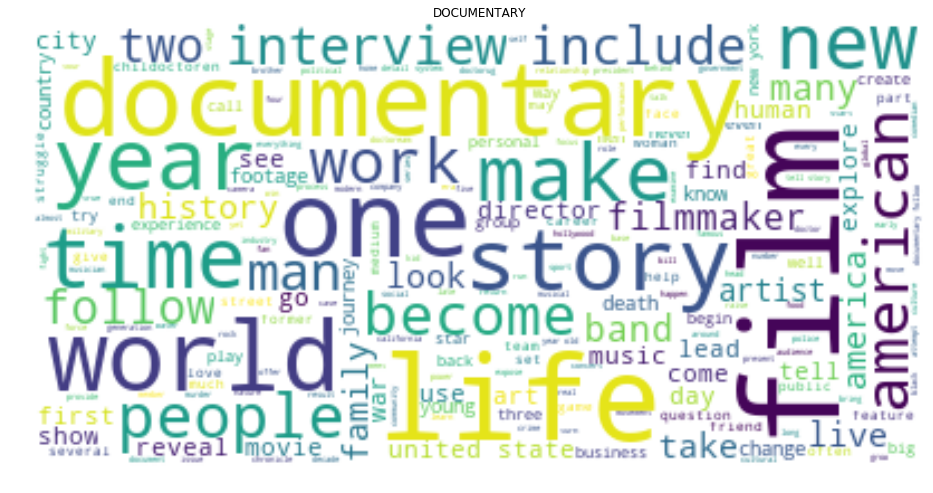

In [35]:
text = dataTraining['plot'][dataTraining['Documentary']==1].str.cat(sep=' ')#.map(lambda x: ''.join(x))
wordcloud = WordCloud(max_font_size=60, background_color="white").generate(text)
plt.figure(figsize=(16,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('DOCUMENTARY')
plt.show()

### Exploring word frequency by genre

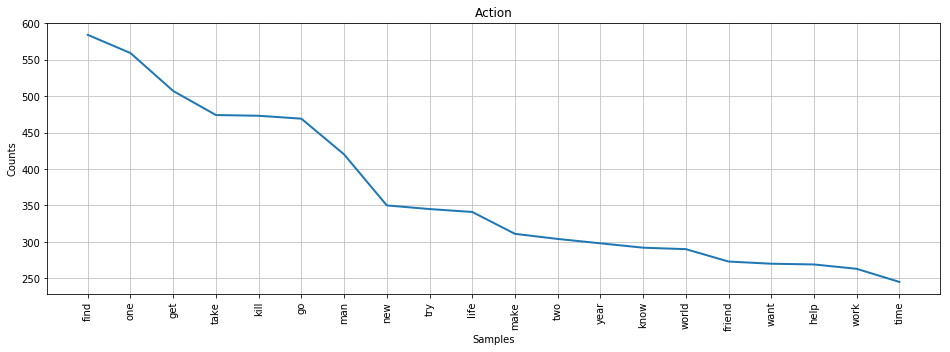

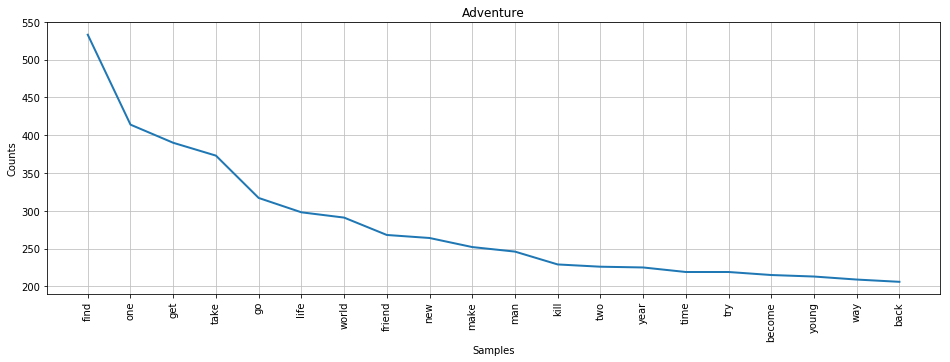

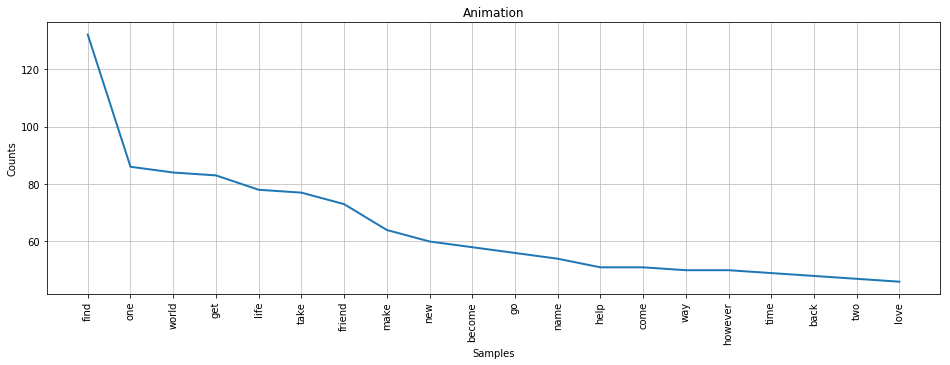

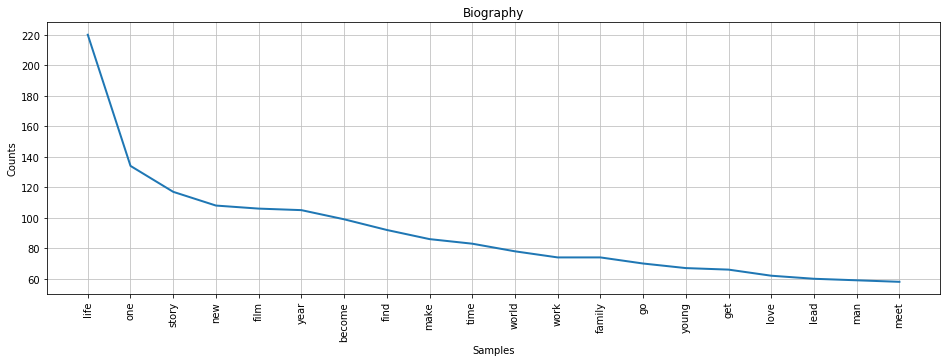

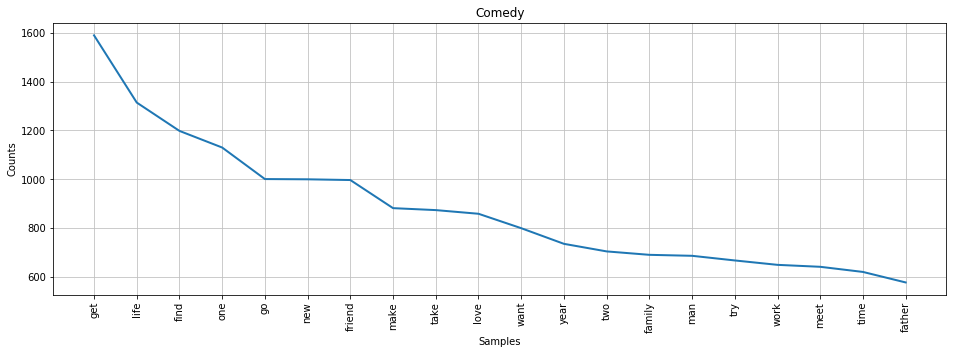

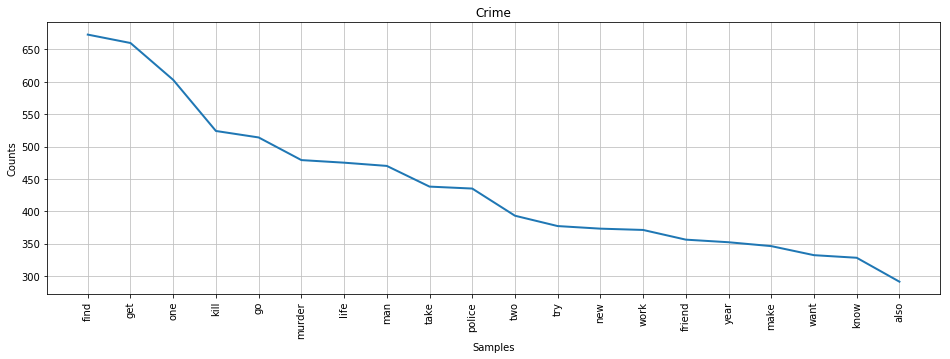

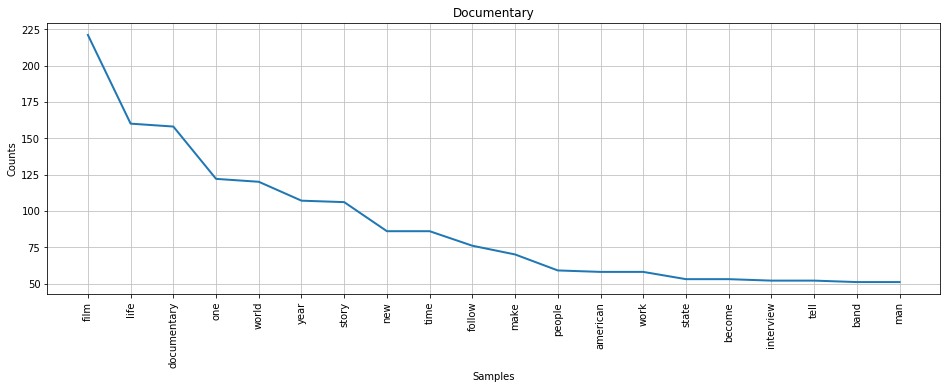

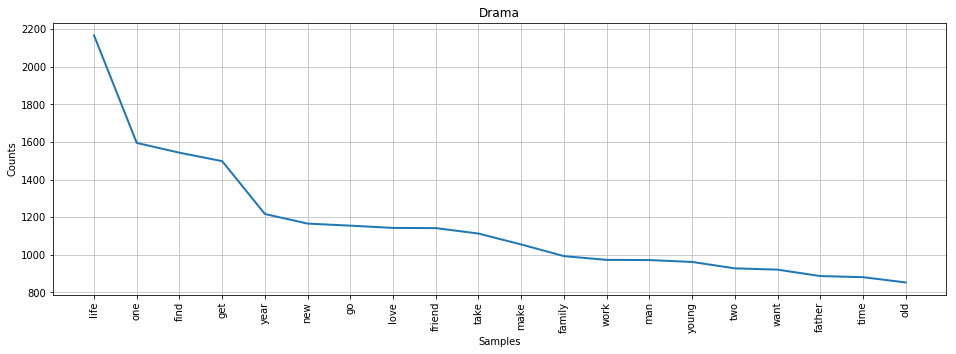

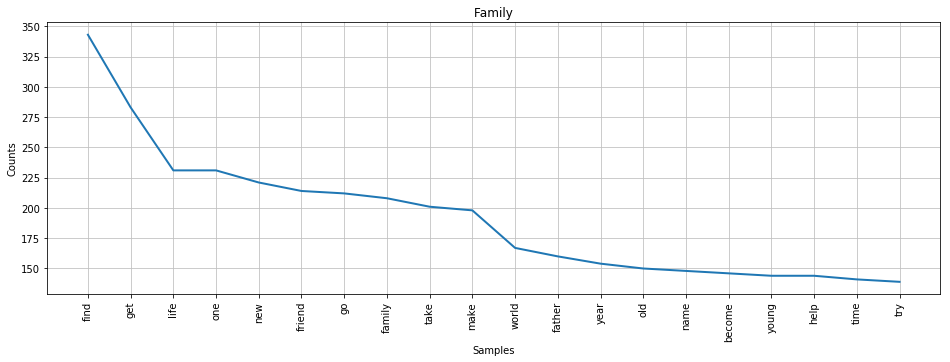

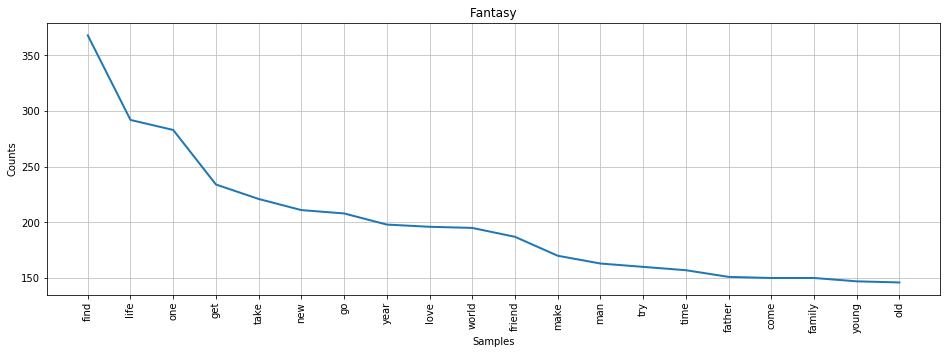

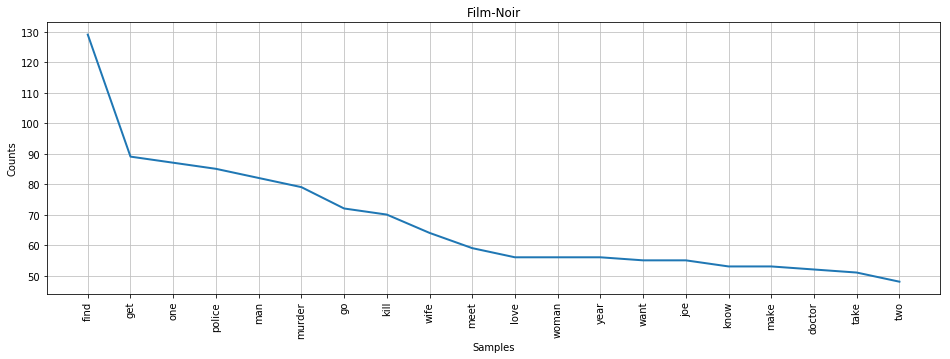

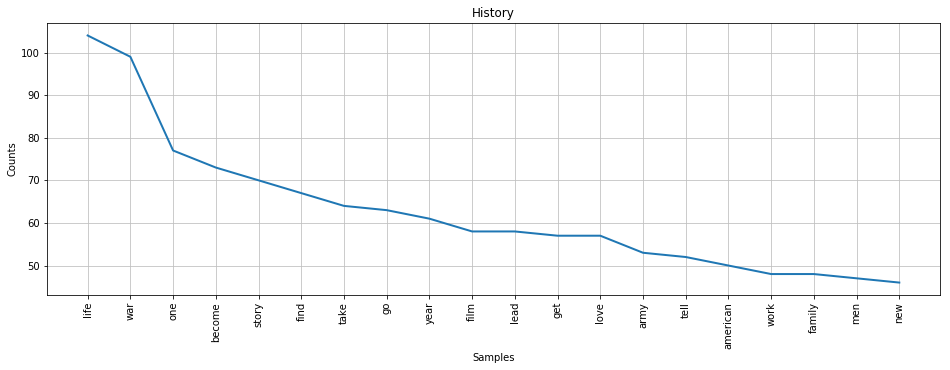

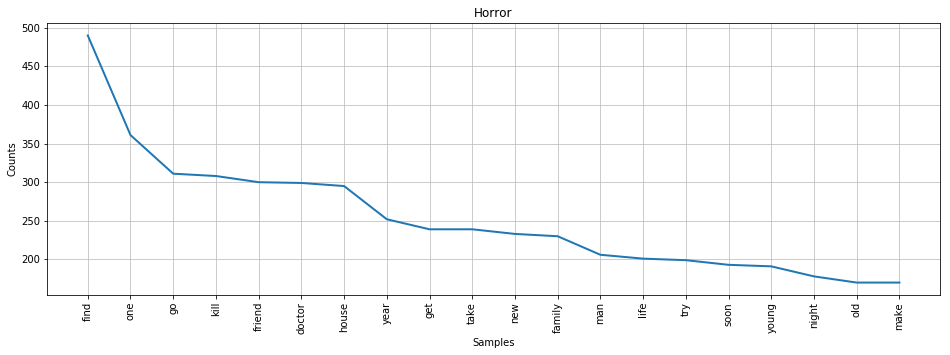

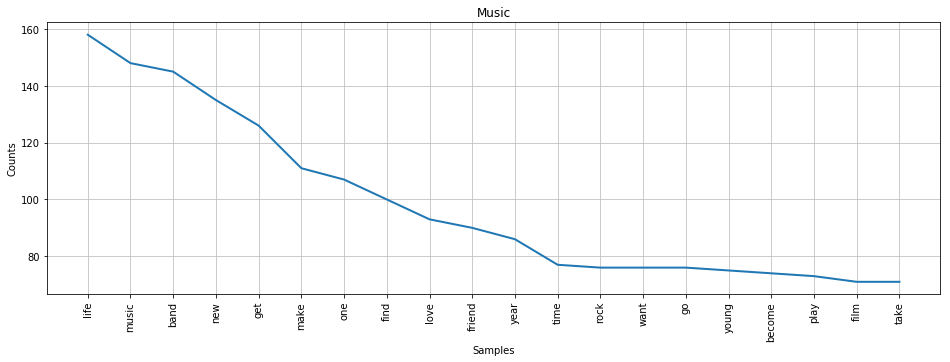

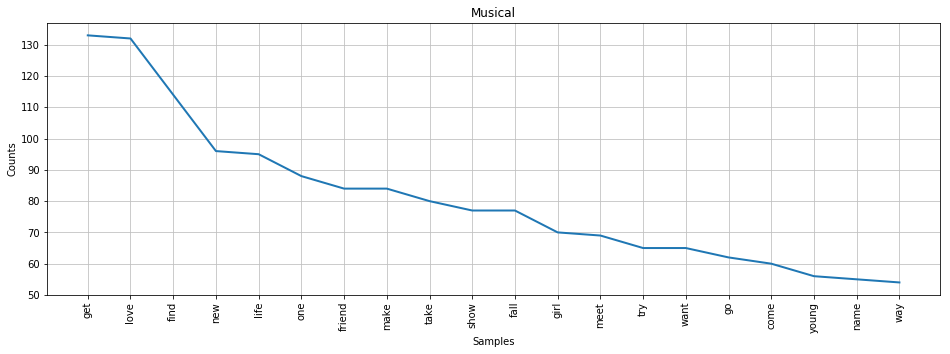

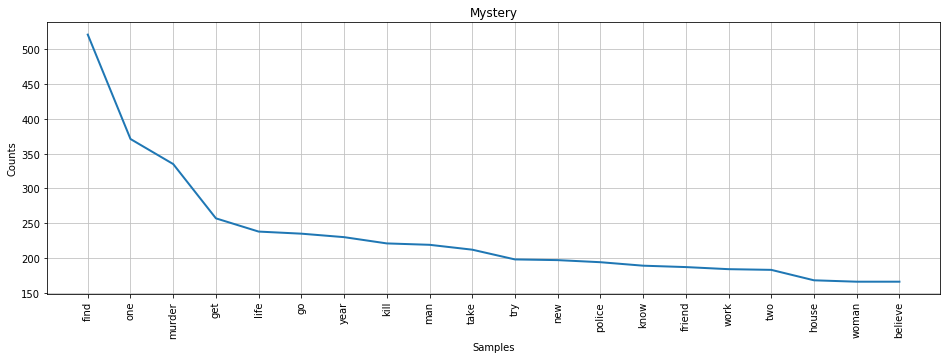

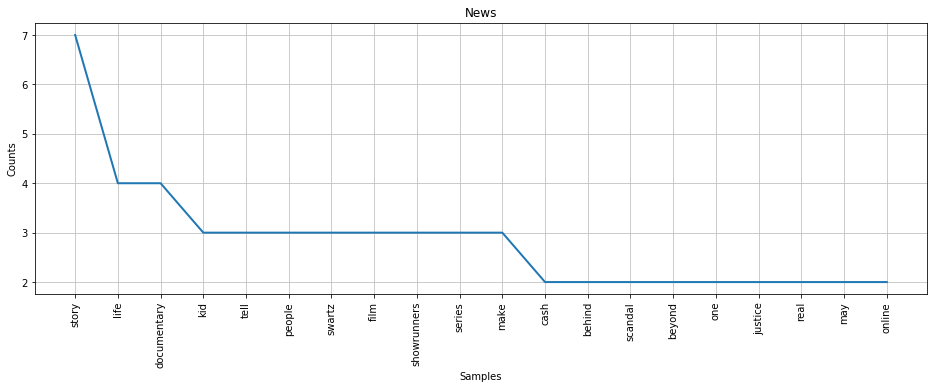

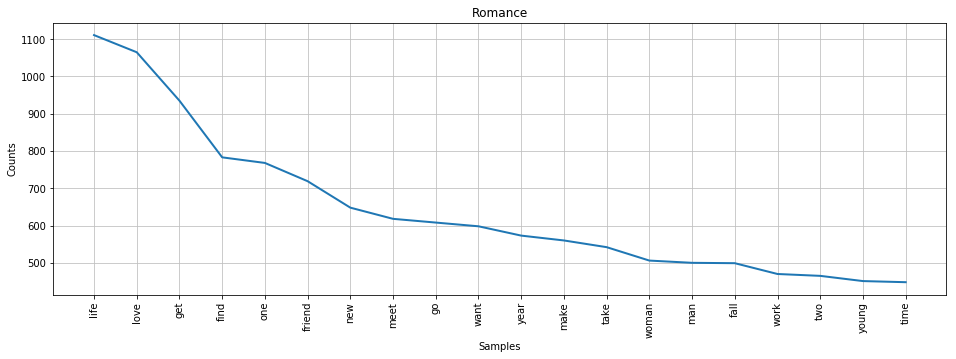

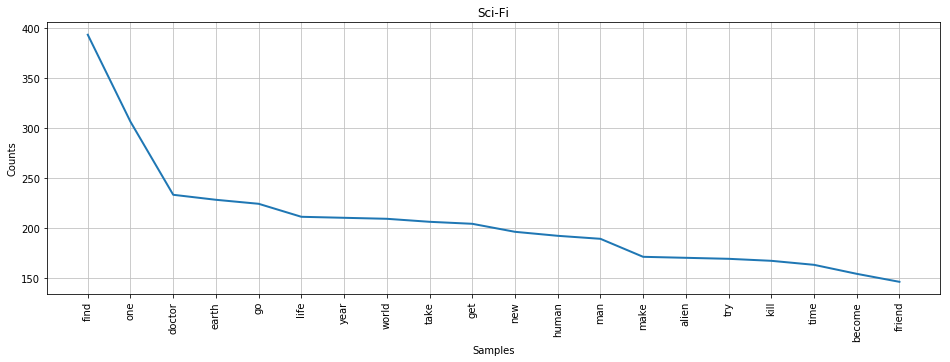

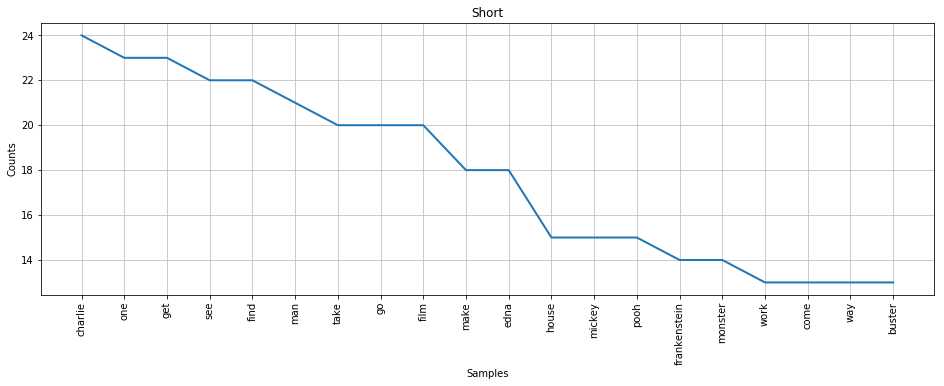

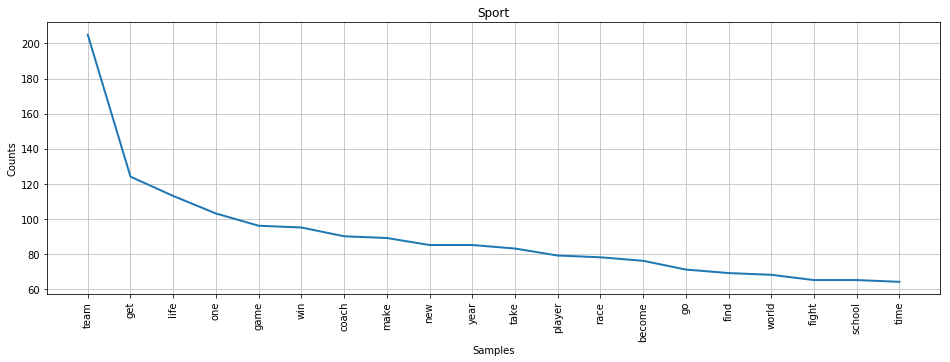

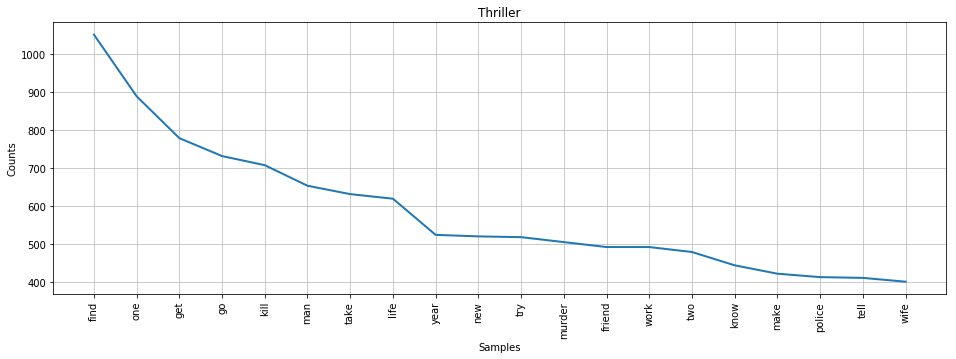

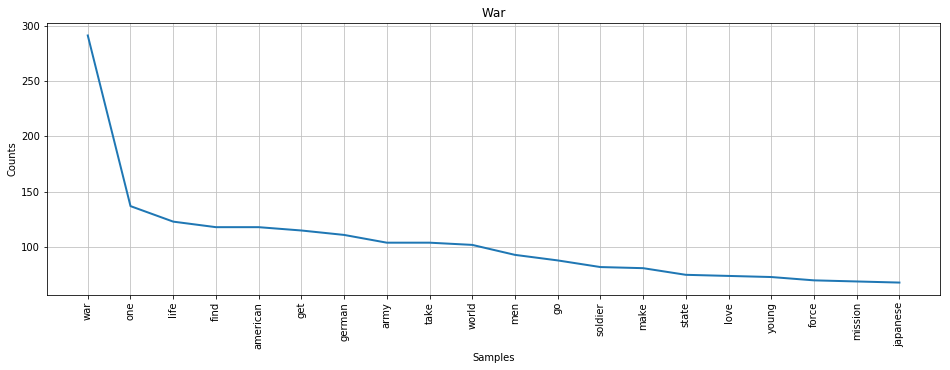

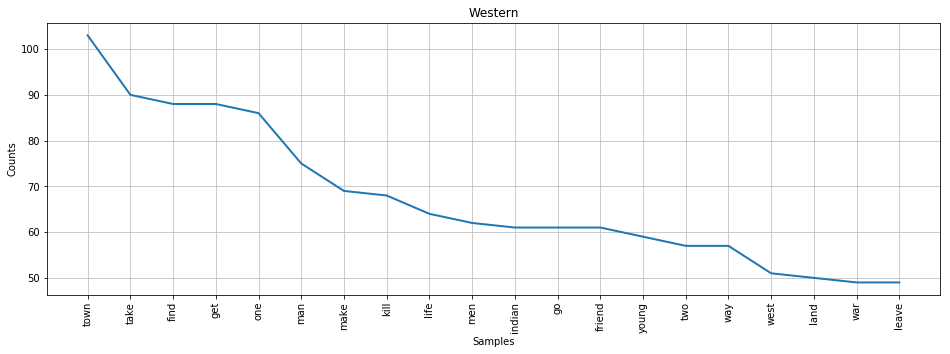

In [33]:
# Checking most commons words by genre
for genre in le.classes_:
    text = dataTraining['plot'][dataTraining[genre]==1].str.cat(sep=' ')#.map(lambda x: ''.join(x))
    freqdist = nltk.FreqDist(nltk.word_tokenize(text))
    plt.figure(figsize=(16,5))
    freqdist.plot(20, title=genre)

Some words are shared in a lot genres, we find these words formally

In [11]:
# get words frequency by genre
dict_freq = {}
for genre in le.classes_:
    text = dataTraining['plot'][dataTraining[genre]==1].str.cat(sep=' ')#.map(lambda x: ''.join(x))
    freqdist = nltk.FreqDist(nltk.word_tokenize(text))
    dict_freq[genre] =freqdist
freqDf = pd.DataFrame.from_dict(dict_freq)
freqDf.fillna(0, inplace = True)

In [35]:
freqDf.head(20)

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
aa,0.00000,0.00000,0.00000,0.00000,2.00000,2.00000,0.00000,4.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,3.00000,1.00000,0.00000,0.00000,2.00000,0.00000,0.00000
aaa,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
aames,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.00000,...,0.00000,2.00000,0.00000,2.00000,2.00000,0.00000,0.00000,2.00000,0.00000,0.00000
aang,2.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.00000,2.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
aaron,22.00000,0.00000,0.00000,2.00000,24.00000,19.00000,2.00000,18.00000,0.00000,7.00000,...,0.00000,4.00000,2.00000,9.00000,13.00000,0.00000,1.00000,19.00000,0.00000,0.00000
aaronow,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,...,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
aback,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
abagnale,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
abalam,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.00000,0.00000,0.00000
abalone,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,3.00000,...,0.00000,3.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,3.00000


Taking the words that are shared around more than 20 genres, tagging like most common words

In [12]:
n_genres = 20
genre_word = (freqDf>0).sum(axis=1)
most_commons_words = set(genre_word[genre_word.map(lambda x: x>n_genres)].keys())

In [41]:
most_commons_words

{'straight',
 'tragedy',
 'persuade',
 'late',
 'shop',
 'brian',
 'courage',
 'emerge',
 'date',
 'heart',
 'eager',
 'sound',
 'famous',
 'europe',
 'last',
 'consequence',
 'pursue',
 'five',
 'old',
 'party',
 'johnny',
 'blind',
 'alive',
 'legendary',
 'ago',
 'quite',
 'command',
 'city',
 'george',
 'student',
 'desire',
 'interested',
 'lawyer',
 'aid',
 'blame',
 'number',
 'african',
 'next',
 'angeles',
 'forest',
 'captain',
 'threat',
 'call',
 'sure',
 'similar',
 'around',
 'view',
 'wear',
 'jealousy',
 'british',
 'reach',
 'power',
 'internal',
 'receive',
 'provide',
 'scott',
 'hit',
 'cash',
 'come',
 'choose',
 'believe',
 'despite',
 'gain',
 'record',
 'rise',
 'connection',
 'strange',
 'challenge',
 'arrest',
 'adventure',
 'michael',
 'credit',
 'onto',
 'security',
 'thief',
 'train',
 'honor',
 'job',
 'master',
 'demand',
 'convinces',
 'camp',
 'fit',
 'witness',
 'alice',
 'feature',
 'mother',
 'theme',
 'determine',
 'official',
 'beloved',
 'photogra

Getting the frequency of most common words by genre

In [13]:
freqCommons = freqDf[freqDf.index.map(lambda x: x in most_commons_words)]

In [43]:
freqCommons.head(20)

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
abandon,17.00000,17.00000,2.00000,9.00000,33.00000,12.00000,1.00000,79.00000,10.00000,8.00000,...,4.00000,14.00000,0.00000,32.00000,13.00000,0.00000,4.00000,32.00000,5.00000,6.00000
ability,32.00000,25.00000,4.00000,5.00000,36.00000,15.00000,0.00000,47.00000,16.00000,29.00000,...,2.00000,13.00000,0.00000,23.00000,37.00000,1.00000,10.00000,39.00000,5.00000,0.00000
able,40.00000,38.00000,4.00000,17.00000,163.00000,72.00000,6.00000,231.00000,35.00000,47.00000,...,14.00000,50.00000,0.00000,132.00000,31.00000,3.00000,13.00000,91.00000,25.00000,11.00000
accept,31.00000,30.00000,9.00000,8.00000,100.00000,47.00000,3.00000,140.00000,23.00000,17.00000,...,12.00000,24.00000,0.00000,85.00000,17.00000,1.00000,11.00000,75.00000,7.00000,9.00000
access,2.00000,4.00000,0.00000,7.00000,9.00000,14.00000,17.00000,17.00000,5.00000,6.00000,...,4.00000,6.00000,1.00000,3.00000,3.00000,0.00000,1.00000,16.00000,1.00000,2.00000
accident,33.00000,29.00000,5.00000,3.00000,70.00000,34.00000,1.00000,127.00000,19.00000,32.00000,...,4.00000,48.00000,0.00000,48.00000,23.00000,0.00000,7.00000,102.00000,5.00000,4.00000
accidentally,14.00000,22.00000,15.00000,1.00000,76.00000,25.00000,0.00000,41.00000,28.00000,28.00000,...,8.00000,10.00000,0.00000,23.00000,17.00000,2.00000,4.00000,30.00000,2.00000,4.00000
accompany,18.00000,24.00000,4.00000,2.00000,28.00000,10.00000,0.00000,31.00000,9.00000,10.00000,...,1.00000,8.00000,0.00000,19.00000,6.00000,0.00000,2.00000,19.00000,5.00000,5.00000
account,9.00000,5.00000,1.00000,10.00000,25.00000,12.00000,5.00000,45.00000,8.00000,9.00000,...,2.00000,16.00000,0.00000,19.00000,3.00000,0.00000,3.00000,24.00000,5.00000,0.00000
accuse,10.00000,8.00000,2.00000,6.00000,21.00000,38.00000,2.00000,55.00000,6.00000,4.00000,...,2.00000,15.00000,0.00000,16.00000,3.00000,1.00000,2.00000,33.00000,4.00000,3.00000


Initially, we though that remove all the "most common words" with low frecuency, but, we can't take off the number of documments: if a word is used 10 times in news genre, which have 10 movies, it's most relevance that a word used 50 times in Drama genre, that have 3500 movies.

Now we want to know, how many movies uses the most common words.

In [14]:
def get_docs_with_word(word):
    word_docs = {}
    plot_g={}
    for genre in le.classes_:
        plot_genre = dataTraining['plot'][dataTraining[genre]==1].map(lambda x: word in x)
        plot_g[genre]= plot_genre.sum()
        #print(genre, plot_genre.sum())
    word_docs[word]= plot_g
    return pd.DataFrame.from_dict(word_docs).T

In [15]:
docs_words = freqCommons.index.map(lambda x: get_docs_with_word(x))
docs_words_ = pd.concat(docs_words)

In [41]:
docs_words_.head(20)

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
abandon,20,15,2,10,34,14,1,80,10,8,...,4,15,0,31,17,0,4,39,5,6
ability,32,25,4,8,56,20,4,85,17,25,...,3,15,0,45,37,1,12,47,12,0
able,170,155,25,63,441,229,44,658,102,104,...,38,132,0,332,119,7,34,309,55,35
accept,34,33,11,9,110,52,7,156,26,17,...,12,26,0,92,19,1,15,76,7,11
access,2,6,0,7,9,16,16,26,2,3,...,1,7,1,4,3,0,1,21,1,1
accident,44,48,20,4,148,59,2,164,48,55,...,11,56,0,71,39,2,12,124,8,8
accidentally,14,22,15,1,75,25,0,40,28,28,...,8,10,0,23,17,2,4,29,2,4
accompany,18,24,4,2,28,10,0,32,9,10,...,1,8,0,19,6,0,2,19,5,5
account,16,6,1,10,41,23,5,57,7,11,...,3,20,0,23,4,0,4,33,5,1
accuse,12,10,2,7,21,39,2,57,5,5,...,2,16,0,17,4,1,2,35,4,3


Now, the relation between most commons words and number of movies.

In [16]:
freq_commons_ratio = freqCommons/docs_words_
freq_commons_ratio.fillna(0, inplace=True)

In [43]:
freq_commons_ratio.head(20).round(2)

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
abandon,0.85000,1.13000,1.00000,0.90000,0.97000,0.86000,1.00000,0.99000,1.00000,1.00000,...,1.00000,0.93000,0.00000,1.03000,0.76000,0.00000,1.00000,0.82000,1.00000,1.00000
ability,1.00000,1.00000,1.00000,0.62000,0.64000,0.75000,0.00000,0.55000,0.94000,1.16000,...,0.67000,0.87000,0.00000,0.51000,1.00000,1.00000,0.83000,0.83000,0.42000,0.00000
able,0.24000,0.25000,0.16000,0.27000,0.37000,0.31000,0.14000,0.35000,0.34000,0.45000,...,0.37000,0.38000,0.00000,0.40000,0.26000,0.43000,0.38000,0.29000,0.45000,0.31000
accept,0.91000,0.91000,0.82000,0.89000,0.91000,0.90000,0.43000,0.90000,0.88000,1.00000,...,1.00000,0.92000,0.00000,0.92000,0.89000,1.00000,0.73000,0.99000,1.00000,0.82000
access,1.00000,0.67000,0.00000,1.00000,1.00000,0.88000,1.06000,0.65000,2.50000,2.00000,...,4.00000,0.86000,1.00000,0.75000,1.00000,0.00000,1.00000,0.76000,1.00000,2.00000
accident,0.75000,0.60000,0.25000,0.75000,0.47000,0.58000,0.50000,0.77000,0.40000,0.58000,...,0.36000,0.86000,0.00000,0.68000,0.59000,0.00000,0.58000,0.82000,0.62000,0.50000
accidentally,1.00000,1.00000,1.00000,1.00000,1.01000,1.00000,0.00000,1.02000,1.00000,1.00000,...,1.00000,1.00000,0.00000,1.00000,1.00000,1.00000,1.00000,1.03000,1.00000,1.00000
accompany,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.00000,0.97000,1.00000,1.00000,...,1.00000,1.00000,0.00000,1.00000,1.00000,0.00000,1.00000,1.00000,1.00000,1.00000
account,0.56000,0.83000,1.00000,1.00000,0.61000,0.52000,1.00000,0.79000,1.14000,0.82000,...,0.67000,0.80000,0.00000,0.83000,0.75000,0.00000,0.75000,0.73000,1.00000,0.00000
accuse,0.83000,0.80000,1.00000,0.86000,1.00000,0.97000,1.00000,0.96000,1.20000,0.80000,...,1.00000,0.94000,0.00000,0.94000,0.75000,1.00000,1.00000,0.94000,1.00000,1.00000


Making a specific stop word by genre, defyning 0.5 like a usability ratio

In [25]:
usability_ratio = 0.5
stop_words_by_genre={}
for genre in le.classes_:
    stop_words_by_genre[genre] = list(freq_commons_ratio[genre][freq_commons_ratio[genre]<usability_ratio].index)

Removing the most common - less used words by genre

In [18]:
def rem_words_genre(sentence, stop_words):
    words = nltk.word_tokenize(sentence)
    new_sentence=[]
    for i, word in enumerate(words):
        if word not in stop_words:
            new_sentence.append(word)
    s = ' '.join(new_sentence)
    return s

In [19]:
dataTrainCopy = dataTraining.copy()

In [35]:
dataTraining = dataTrainCopy

In [26]:
for genre in genres:
    dataTraining['plot'][dataTraining[genre]==1]=dataTraining['plot'][dataTraining[genre]==1].map(lambda x: rem_words_genre(x,stop_words_by_genre[genre]))

Finally, concat the title, year and rating on the plot

In [21]:

def data_processing(df):
    p = inflect.engine()
    #p.number_to_words(99)
    df['plot']=df["title"].map(str) + " - "+ df["year"].map(p.number_to_words) + " - " + df["plot"]+" - "+df["rating"].map(p.number_to_words)
    df['plot']=df["title"].map(str) + " - "+ df["year"].map(p.number_to_words) + " - " + df["plot"]+" - "+df["rating"].map(p.number_to_words)
    return df

In [36]:
dataTraining = data_processing(dataTraining)
dataTraining['plot'] = dataTraining['plot'].apply(clean_sentence)

### 5. Training

Grid search: looking a prior better estimator. Previosly, we test performance a champion challenge over _SGDClassifier_, _RandomForestClassifier_ and _MultinomialNB_, getting best performance with _MultinomialNB_

In [ ]:

#X_train, X_test, y_train_genres, y_test_genres = train_test_split(dataTraining['plot'], y_genres, test_size=0.2, random_state=42)

from sklearn.model_selection import GridSearchCV

parameters = {'vect__max_features': [2700,2800, 2950,3000,3100]
              ,'vect__ngram_range': [(1,1),(1,2)]
              #,'vect__binary':[True, False]
              ,'vect__min_df':[10,12,14,15,16,17]
              #,'vect__max_df':[0.8, 0.9, 0.95, 1.0 ]
              #,'clf__estimator__alpha': [0.7, 0.8, 0.9, 1.0, 1.2]
              ,'clf__estimator__alpha': [0.6, 0.65, 0.7, 0.72]
              #,'clf__estimator__fit_prior': [True, False]
                }

text_clf = Pipeline([('vect',CountVectorizer()),
                    ('clf',OneVsRestClassifier(MultinomialNB()))])#

gs_clf = GridSearchCV(estimator = text_clf, param_grid = parameters, n_jobs=-1, cv=10, scoring='roc_auc')

gs_clf = gs_clf.fit(dataTraining['plot'], y_genres)


In [28]:
gs_clf.best_score_

0.8885740437187459

In [29]:
gs_clf.best_params_

{'clf__estimator__alpha': 0.65,
 'vect__max_features': 2800,
 'vect__min_df': 14,
 'vect__ngram_range': (1, 2)}

Applying hyper values on a Kfold cross validation, with 10 splits.

In [28]:

kf = KFold(n_splits=10, random_state=None, shuffle=False)

roc_ = []

text_clf = Pipeline([('vect', CountVectorizer(max_features=2800, ngram_range = (1,2), binary=True, lowercase=True
                                            ,min_df=14, max_df=1.0
                                             )
                        ),
                    ('clf',OneVsRestClassifier(MultinomialNB(fit_prior = False
                                                             ,alpha=0.65#0.72
                                                            ))
                    )
                    ])

for train_index, test_index in kf.split(dataTraining):
    
    X_train, y_train = dataTraining['plot'].iloc[train_index], y_genres[train_index]
   
    X_test, y_test = dataTraining['plot'].iloc[test_index], y_genres[test_index]
    
    text_clf.fit(X_train, y_train)
    
    y_pred_genres = text_clf.predict_proba(X_test)
        
    try:
        roc_.append(roc_auc_score(y_test, y_pred_genres))#, average='macro'))
    except ValueError:
        pass
print(np.mean(roc_))
roc_

0.9000660813998559


[0.8999163548573055,
 0.8990961944351307,
 0.9000807709164943,
 0.898997004699794,
 0.9022400820905551]

The above result is used as base to performance a genre by genre vectorizer and classifier. We defined a particular vectorization by genre, and saving in a dictionary.

In [29]:
pipe_genre={}
for genre in genres:
    if genre == 'Action':
        vectorizer = {'tfidf':TfidfVectorizer(max_features=2700, ngram_range = (1,2), binary=True, lowercase=True
                                            ,min_df=9, max_df=1.0
                                             )
                     }
        classifier = {
              'multinomial_nb': MultinomialNB(alpha=0.5, fit_prior = False),
             }
    else:
        if genre == 'Adventure':
            vectorizer = {'tfidf':TfidfVectorizer(max_features=3200, ngram_range = (1,2), binary=False, lowercase=True
                                                ,min_df=12, max_df=0.9
                                                 )
                         }
            classifier = {
                  'multinomial_nb':MultinomialNB(fit_prior = False
                                            ,alpha=0.3
                                            )
                }
        else:
            if genre == 'Drama':

                vectorizer = {'tfidf':TfidfVectorizer(max_features=4600, ngram_range = (1,2), binary=True, lowercase=True
                                                    ,min_df=14, max_df=1.0
                                                     )
                             }

                classifier = {
                      'multinomial_nb':MultinomialNB(fit_prior = True
                                                ,alpha=2.0
                                                )
                            }

            else:
                vectorizer = {'count':CountVectorizer(max_features=4000
                                              , ngram_range = (1,2)
                                              ,binary=True
                                              ,min_df=16
                                              ,max_df=1.0
                                             ), 
                     }
                classifier = {
                      'multinomial_nb': MultinomialNB(alpha=0.72, fit_prior = False),
                     }
    pipe_genre[genre] = [vectorizer,classifier]

In [30]:
n_vec = len(vectorizer)
n_clf = len(classifier)

n_iterations = n_vec*n_clf

Running all the models, aplying a smote over sampling to specific movie genres

In [45]:
test_result = {}
for genre in genres:
    vectorizer = pipe_genre[genre][0]
    classifier = pipe_genre[genre][1]
    y_genre = dataTraining[genre]
    k = 1
    final_score = {}
    for vect_name, vect in vectorizer.items():
        for clf_name, clf in classifier.items():
            print(genre.upper() + ' [' + str(k) + '/' +str(n_iterations) + ']: ' + vect_name + ' - ' + clf_name )
            kf = KFold(n_splits=3, random_state=None, shuffle=False)
            pipe = Pipeline([('vect', vect), ('clf', clf)])

            auc = []
            
            #remove words from specific genre
            if genre=='Drama':
                dataTraining['plot'][dataTraining[genre]==1]=dataTraining['plot'][dataTraining[genre]==1].map(lambda x: rem_words_genre(x,stop_words_by_genre[genre]))
            
            for train_index, test_index in kf.split(dataTraining['plot']):
                X_train, y_train = dataTraining['plot'].iloc[train_index], y_genre.iloc[train_index]
                X_test, y_test = dataTraining['plot'].iloc[test_index], y_genre.iloc[test_index]
                
                if genre in ['News', 'Documentary', 'Film-Noir', 'Horror', 'Sport', 'Western', 'War']:
                    train_vect = vect.fit_transform(X_train)
                    try:
                        train_vect_over, y_train_over = SMOTE().fit_sample(train_vect, y_train) 
                    except:
                        train_vect_over, y_train_over = train_vect, y_train
                    
                    test_vect = vect.transform(X_test)
                    clf.fit(train_vect_over, y_train_over)
                    y_pred = clf.predict_proba(test_vect)
                else:
                    pipe.fit(X_train, y_train)
                    y_pred = pipe.predict_proba(X_test)

                try:
                    auc.append(roc_auc_score(y_test, y_pred[:,1]))
                except:
                    continue
                    
            print('Summary: ' +                 
                  'auc = ' + str(round(np.mean(auc),2))
                 )
            print()
            k+=1
            final_score[(vect_name, clf_name)] = np.mean(auc)
        print('------')
    test_result[genre] = max(final_score, key=final_score.get)

ACTION [1/1]: tfidf - multinomial_nb
Summary: auc = 0.9

------
ADVENTURE [1/1]: tfidf - multinomial_nb
Summary: auc = 0.86

------
ANIMATION [1/1]: count - multinomial_nb
Summary: auc = 0.91

------
BIOGRAPHY [1/1]: count - multinomial_nb
Summary: auc = 0.86

------
COMEDY [1/1]: count - multinomial_nb
Summary: auc = 0.83

------
CRIME [1/1]: count - multinomial_nb
Summary: auc = 0.9

------
DOCUMENTARY [1/1]: count - multinomial_nb
Summary: auc = 0.9

------
DRAMA [1/1]: tfidf - multinomial_nb
Summary: auc = 0.8

------
FAMILY [1/1]: count - multinomial_nb
Summary: auc = 0.9

------
FANTASY [1/1]: count - multinomial_nb
Summary: auc = 0.85

------
FILM-NOIR [1/1]: count - multinomial_nb
Summary: auc = 0.59

------
HISTORY [1/1]: count - multinomial_nb
Summary: auc = 0.9

------
HORROR [1/1]: count - multinomial_nb
Summary: auc = 0.8

------
MUSIC [1/1]: count - multinomial_nb
Summary: auc = 0.89

------
MUSICAL [1/1]: count - multinomial_nb
Summary: auc = 0.85

------
MYSTERY [1/1]: 

In [46]:
test_result

{'Action': ('tfidf', 'multinomial_nb'),
 'Adventure': ('tfidf', 'multinomial_nb'),
 'Animation': ('count', 'multinomial_nb'),
 'Biography': ('count', 'multinomial_nb'),
 'Comedy': ('count', 'multinomial_nb'),
 'Crime': ('count', 'multinomial_nb'),
 'Documentary': ('count', 'multinomial_nb'),
 'Drama': ('tfidf', 'multinomial_nb'),
 'Family': ('count', 'multinomial_nb'),
 'Fantasy': ('count', 'multinomial_nb'),
 'Film-Noir': ('count', 'multinomial_nb'),
 'History': ('count', 'multinomial_nb'),
 'Horror': ('count', 'multinomial_nb'),
 'Music': ('count', 'multinomial_nb'),
 'Musical': ('count', 'multinomial_nb'),
 'Mystery': ('count', 'multinomial_nb'),
 'News': ('count', 'multinomial_nb'),
 'Romance': ('count', 'multinomial_nb'),
 'Sci-Fi': ('count', 'multinomial_nb'),
 'Short': ('count', 'multinomial_nb'),
 'Sport': ('count', 'multinomial_nb'),
 'Thriller': ('count', 'multinomial_nb'),
 'War': ('count', 'multinomial_nb'),
 'Western': ('count', 'multinomial_nb')}

In [47]:
pipe_dict = {}
for genre in genres:
    
    vectorizer = pipe_genre[genre][0]
    classifier = pipe_genre[genre][1]
    
    y_genre = dataTraining[genre]
    vect_name = test_result[genre][0]
    clf_name = test_result[genre][1]
    
    vect = clone(vectorizer[vect_name])
    clf = clone(classifier[clf_name])
    
    if genre=='Drama':
        dataTraining['plot'][dataTraining[genre]==1]=dataTraining['plot'][dataTraining[genre]==1].map(lambda x: rem_words_genre(x,stop_words_by_genre[genre]))
    
    if genre in ['News', 'Documentary', 'Film-Noir', 'Horror', 'Sport', 'Western', 'War']:
        X_vect = vect.fit_transform(dataTraining['plot'])
        try:
            X_vect_over, y_over = SMOTE().fit_sample(X_vect, y_genre) 
        except:
            X_vect_over, y_over = X_vect, y_genre
        
        clf.fit(X_vect_over, y_over)

    else:
       
        X_vect = vect.fit_transform(dataTraining['plot'])
    
        clf.fit(X_vect, y_genre)
                    
#    X_vect = vect.fit_transform(dataTraining['plot'])
    
#    clf.fit(X_vect, y_genre)
    
    pipe_dict[genre] = Pipeline([('vect', vect), ('clf', clf)])

Saving all the model trained

In [48]:
joblib.dump(pipe_dict,'pipe_dict_fit_')

['pipe_dict_fit_']

In [52]:
pipe_dict = joblib.load('pipe_dict_fit_')

In [53]:
def rem_words_genre(sentence, stop_words):
    words = nltk.word_tokenize(sentence)
    new_sentence=[]
    for i, word in enumerate(words):
        if word not in stop_words:
            new_sentence.append(word)
    s = ' '.join(new_sentence)
    return s

def predict_genre(s, pipe_dict):
    s_new = clean_sentence(s)

    genre_analyzed = []
    proba = []
    for genre, pipe in pipe_dict.items():    
        #if genre=='Drama':
        #    s_new = rem_words_genre(s_new,stop_words_by_genre[genre])
        res = pipe.predict_proba([s_new])
        genre_analyzed.append(genre)
        proba.append(res[0][1])
    data = pd.DataFrame({'genre': genre_analyzed, 'proba': proba})
    data = data.sort_values(by='proba', ascending=True)
    ax = data.plot(x='genre', y='proba', kind='barh')
    plt.show()

In [165]:
pd.set_option('display.max_colwidth', -1)
dataTesting.sample(1)

,year,title,plot
11090,1982,Kiss Me Goodbye,"kay villano ' s a woman whose husband , jolly , who ' s a renowned choreographer , died three years ago . she has met someone else and is going marry him . she also decides to return to the house where she and jolly lived . and it ' s not long after that she sees him , who tells her that he ' s a ghost that only she can see . and when she starts talking to herself , everybody thinks she ' s nuts . she and jolly try to settle things . and her fiance is questioning if she does want to marry him ."


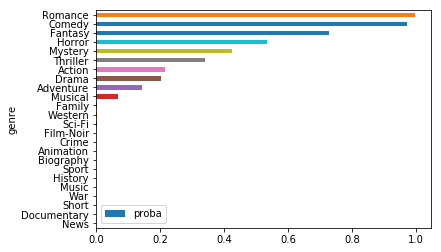

In [56]:
predict_genre(dataTesting['plot'][11090], pipe_dict)

### Predict Testing Dataset

In [57]:
def predict_genre_prob(s):
    s = clean_sentence(s)
    genre_analyzed = []
    proba = []
    for genre, pipe in pipe_dict.items():
        #if genre=='Drama':
        #    s = rem_words_genre(s,stop_words_by_genre[genre])
        res = pipe.predict_proba([s])
        genre_analyzed.append(genre)
        proba.append(res[0][1])
    return proba

In [58]:
dataTesting['plot'] = dataTesting['plot'].apply(clean_sentence)

Previosly we create a Random Forest Regressor to predict a rating movie.

In [59]:
def predict_rating(df):

    vect = CountVectorizer(max_features=1500, ngram_range = (1,2), binary=True, lowercase=True,
                                            min_df=16, max_df=1.0
                                             )
    X_vect = vect.fit_transform(df['plot'])
    reg_rating = joblib.load('model_rating_predict_2')
    y_pred = reg_rating.predict(X_vect)
    return y_pred

In [60]:
dataTesting['rating'] = predict_rating(dataTesting).round(2)

In [61]:
dataTesting = data_processing(dataTesting)

In [62]:
dataTesting['plot'] = dataTesting['plot'].apply(clean_sentence)

In [63]:
dataTesting.head()

,year,title,plot,rating
1,1999,Message in a Bottle,message bottle one thousand nine hundoctored message bottle one thousand nine hundoctored meet fate shall seal fate theresa osborne run along beach stumble upon bottle wash shore inside message re...,6.04
4,1978,Midnight Express,midnight express one thousand nine hundoctored midnight express one thousand nine hundoctored true story billy hayes american college student catch smuggle doctorugs turkey throw prison six point ...,6.37
5,1996,Primal Fear,primal fear one thousand nine hundoctored primal fear one thousand nine hundoctored martin vail leave chicago da office become successful criminal lawyer success predicate work high profile case f...,6.50
6,1950,Crisis,crisis one thousand nine hundoctored fifty crisis one thousand nine hundoctored fifty husband wife american doctor eugene helen ferguson renowned neurosurgeon travel latin america vacation make de...,6.64
7,1959,The Tingler,tingler one thousand nine hundoctored tingler one thousand nine hundoctored coroner scientist doctor warren chapin research shiver effect fear assistant david morris doctor warren introduce ollie ...,6.00


In [201]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

In [64]:
y_pred_test_genres = dataTesting['plot'].apply(predict_genre_prob)

In [65]:
res = pd.DataFrame(y_pred_test_genres.tolist(), index=dataTesting.index, columns=cols)

In [66]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
res.head()

,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
1,0.34727,0.51523,0.00023,0.00000,0.93918,0.00099,0.00000,0.18960,0.35230,0.95810,...,0.67632,0.75980,0.00000,0.43366,0.00098,0.00000,0.00013,0.23729,0.00000,0.00009
4,0.26111,0.14856,0.00017,0.98736,0.02473,0.86145,0.00085,0.78248,0.00309,0.00002,...,0.13307,0.00566,0.00000,0.02274,0.00002,0.00016,0.39851,0.02400,0.11819,0.01329
5,0.18782,0.06014,0.00000,0.00000,0.00003,1.00000,0.00000,0.18285,0.00000,0.00000,...,0.00000,0.99998,0.00000,0.00010,0.00000,0.00000,0.00000,0.99998,0.00000,0.00000
6,0.26122,0.28963,0.00000,0.00000,0.00038,0.00056,0.00000,0.46603,0.00000,0.00000,...,0.00339,0.00435,0.00000,0.04999,0.00004,0.00000,0.00000,0.63274,0.87612,0.00163
7,0.44394,0.20238,0.02557,0.00000,0.00073,0.01206,0.00000,0.12399,0.00374,0.92065,...,0.00000,0.40572,0.00000,0.00000,1.00000,0.00126,0.00000,0.92258,0.00000,0.00000


In [209]:
res.to_csv('pred_genres_text_RF_20190422_1.csv', index_label='ID')

### API

_________

Has been created the API for the project developed above. This API is hosted in Amazon Web Services (AWS).

The API can be accessed through the following IP address: http://3.14.68.98:8888

Link to API Prediction directly:

http://3.14.68.98:8888/predict/?Year=2002&Title=%22Solaris%22&Plot=%22dr%20.%20%20gibarian%20%2C%20%20part%20of%20a%20team%20at%20a%20space%20station%20studying%20solaris%20%2C%20%20makes%20an%20urgent%20and%20self%20-%20described%20bizarre%20video%20request%20to%20his%20friend%20%2C%20%20civilian%20psychiatrist%20dr%20.%20%20chris%20kelvin%20%2C%20%20to%20come%20to%20the%20station%20to%20deal%20with%20an%20unspecified%20phenomenon%20aboard%20%2C%20%20that%20phenomenon%20with%20which%20chris%20%27%20%20experience%20and%20background%20may%20be%20able%20to%20explain%20and%20solve%20.%20%20chris%20learns%20that%20his%20trip%20is%20sanctioned%20by%20the%20space%20program%20as%20a%20security%20force%20had%20been%20sent%20to%20the%20station%20to%20investigate%20%2C%20%20that%20security%20team%20which%20is%20now%20missing%20.%20%20when%20chris%20arrives%20at%20the%20station%20%2C%20%20he%20finds%20only%20two%20surviving%20team%20members%20%2C%20%20drs%20.%20%20gordon%20and%20snow%20%20(%20dr%20.%20%20gibarian%20committed%20suicide%20)%20%20%2C%20%20who%20are%20both%20acting%20nervously%20.%20%20chris%20also%20finds%20two%20unexpected%20people%20there%20%2C%20%20the%20first%20%2C%20%20who%20chris%20only%20sees%20fleetingly%20%2C%20%20being%20dr%20.%20%20gibarian%20%27%20s%20adolescent%20son%20michael%20%2C%20%20and%20the%20second%20being%20chris%20%27%20%20deceased%20wife%20%2C%20%20rheya%20.%20%20chris%20and%20rheya%20had%20a%20passionate%20relationship%20in%20all%20its%20good%20and%20bad%20before%20she%20committed%20suicide%20.%20%20apparently%20%2C%20%20these%20appearances%20of%20loved%20ones%20of%20the%20crew%20at%20the%20station%20are%20what%20chris%20has%20come%20to%20investigate%20.%20%20as%20chris%20%2C%20%20gordon%20and%20snow%20discuss%20and%20argue%20about%20what%20to%20do%20%2C%20%20chris%20becomes%20emotionally%20invested%20in%20this%20vision%20of%20his%20wife%20%2C%20%20who%20herself%20begins%20to%20realize%20she%20looks%20like%20rheya%20%2C%20%20acts%20like%20rheya%20%20(%20including%20having%20the%20same%20feelings%20for%20chris%20)%20%20%2C%20%20answers%20to%20the%20name%20rheya%20%2C%20%20but%20is%20not%20really%20the%20rheya%20that%20was%20once%20chris%20%27%20%20wife%20.%22

**Screenshots of the API:**

<img src="https://github.com/ggrmos/Projects/blob/master/DataMining/Project_2_Movie_Genre_Classification/API.PNG?raw=true"
     style="float: left; width:957px;height:684px;margin-right: 10px;" />